In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

Files already downloaded and verified


In [4]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


# Display Random Image

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch

#def imshow(img):
#    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.axis('off')
#    plt.show()

def imshow(img, upscale_factor=4):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg.shape)

    plt.figure(figsize=(upscale_factor, upscale_factor))
    if npimg.shape[0] == 3:
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    else:
        plt.imshow(npimg, cmap='gray')
        
    #print(np.shape(np.transpose(npimg, (1, 2, 0))))
    plt.axis('off')
    plt.show()

In [7]:
def display_image(dataset,idx=-1):
    # Get a random index if idx is not specified
    if idx == -1:
        idx = torch.randint(0, len(dataset), (1,)).item()
    #print(idx)
    
    # Get the image and label at the random index
    img, label = dataset[idx]
    #print(dataset[idx])
    
    # Display the image
    imshow(img,1)
    
    # Print the label
    print(f"Label: {classes[label]}")

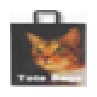

Label: cat


In [8]:
display_image(trainset,3000)

In [9]:

def convert_to_grayscale(dataset):
    new_dataset = []
    for img, label in dataset:
        weights = torch.tensor([0.2989, 0.5870, 0.1140]).view( 3, 1, 1)
        # Convert to grayscale
        gray_img  = torch.sum(img * weights, dim=0)

        new_val = [gray_img,label]
        new_dataset.append(new_val)
    return new_dataset

In [10]:
trainset_grayscale = convert_to_grayscale(trainset)
testset_grayscale = convert_to_grayscale(testset)

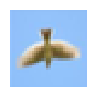

Label: bird


In [12]:
idx = 9876
display_image(trainset,idx)

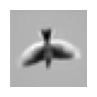

Label: bird


In [13]:
display_image(trainset_grayscale,idx)

# Build a PyTorch Network to train

In [14]:
import torch
import torch.nn as nn


In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        self.dec3 = DoubleConv(512 , 256)
        self.dec2 = DoubleConv(256, 128)
        self.dec1 = DoubleConv(128, 64)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        #print(f"After enc1: {e1.shape}")
        
        e2 = self.enc2(self.pool(e1))
        #print(f"After enc2: {e2.shape}")
        
        e3 = self.enc3(self.pool(e2))
        #print(f"After enc3: {e3.shape}")
        
        e4 = self.enc4(self.pool(e3))
        #print(f"After enc4: {e4.shape}")
        
        # Decoder
        d3 = self.upconv3(e4)
        #print(f"After upconv3: {d3.shape}")
        d3 = torch.cat([d3, e3], dim=1)
        #print(f"After concat with e3: {d3.shape}")
        d3 = self.dec3(d3)
        #print(f"After dec3: {d3.shape}")
        
        d2 = self.upconv2(d3)
        #print(f"After upconv2: {d2.shape}")
        d2 = torch.cat([d2, e2], dim=1)
        #print(f"After concat with e2: {d2.shape}")
        d2 = self.dec2(d2)
        #print(f"After dec2: {d2.shape}")
        
        d1 = self.upconv1(d2)
        #print(f"After upconv1: {d1.shape}")
        d1 = torch.cat([d1, e1], dim=1)
        #print(f"After concat with e1: {d1.shape}")
        d1 = self.dec1(d1)
        #print(f"After dec1: {d1.shape}")
        
        out = self.final_conv(d1)
        #print(f"Final output shape: {out.shape}")
        
        return out

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [259]:
torch.rand(1,32,32).shape

torch.Size([1, 32, 32])

In [18]:
#model(torch.rand(1,1,32,32).to(device))

# Define Data loader and training


In [19]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm, trange


In [20]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        #self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_image = self.input_data[idx]
        target_image = self.target_data[idx]
        
        #if self.transform:
        #    input_image = self.transform(input_image)
        #    target_image = self.transform(target_image)
        
        return input_image, target_image

# Hyperparameters
batch_size = 32
learning_rate = 0.001
weight_decay = 0.01  # AdamW weight decay parameter
num_epochs = 100


In [21]:
#extract only images from the grayscale dataset
input_data = [img.unsqueeze(0) for img, _ in trainset_grayscale]
target_data = [img.unsqueeze(0) for img, _ in trainset]

In [22]:
dataset = CustomDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)


In [24]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [25]:
#Number of parameters that are trainable

sum(p.numel() for p in model.parameters() if p.requires_grad)

7701955

In [26]:
from torchsummary import summary
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]             640
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
        DoubleConv-7           [-1, 64, 32, 32]               0
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [33]:
inputs

NameError: name 'inputs' is not defined

In [275]:
for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    running_loss = 0.0
    
    # tqdm wrapper for dataloader
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item() * inputs.size(0)
        
        # Update progress bar
        pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})
    
    epoch_loss = batch_loss / len(dataset)
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), "unet_model.pth")

print("Training completed!")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]/home/sushruth/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 3, 32, 32])) that is different to the input size (torch.Size([32, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/sushruth/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 3, 32, 32])) that is different to the input size (torch.Size([16, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epochs:   1%|          | 1/100 [00:34<57:14, 34.69s/it]

Epoch [1/100], Loss: 0.2469


Epochs:   2%|▏         | 2/100 [01:08<56:09, 34.39s/it]

Epoch [2/100], Loss: 0.2459


Epochs:   3%|▎         | 3/100 [01:43<55:51, 34.56s/it]

Epoch [3/100], Loss: 0.2456


Epochs:   4%|▍         | 4/100 [02:18<55:34, 34.73s/it]

Epoch [4/100], Loss: 0.2454


Epochs:   5%|▌         | 5/100 [02:53<55:05, 34.79s/it]

Epoch [5/100], Loss: 0.2449


Epochs:   6%|▌         | 6/100 [03:29<54:56, 35.07s/it]

Epoch [6/100], Loss: 0.2450


Epochs:   7%|▋         | 7/100 [04:03<53:48, 34.72s/it]

Epoch [7/100], Loss: 0.2446


Epochs:   8%|▊         | 8/100 [04:37<53:13, 34.71s/it]

Epoch [8/100], Loss: 0.2445


Epochs:   9%|▉         | 9/100 [05:13<52:56, 34.90s/it]

Epoch [9/100], Loss: 0.2445


Epochs:  10%|█         | 10/100 [05:47<52:03, 34.70s/it]

Epoch [10/100], Loss: 0.2441


Epochs:  11%|█         | 11/100 [06:23<51:56, 35.02s/it]

Epoch [11/100], Loss: 0.2442


Epochs:  12%|█▏        | 12/100 [06:57<50:55, 34.73s/it]

Epoch [12/100], Loss: 0.2440


Epochs:  13%|█▎        | 13/100 [07:31<50:17, 34.68s/it]

Epoch [13/100], Loss: 0.2440


Epochs:  14%|█▍        | 14/100 [08:07<50:02, 34.91s/it]

Epoch [14/100], Loss: 0.2436


Epochs:  15%|█▌        | 15/100 [08:42<49:36, 35.02s/it]

Epoch [15/100], Loss: 0.2438


Epochs:  16%|█▌        | 16/100 [09:17<48:58, 34.98s/it]

Epoch [16/100], Loss: 0.2435


Epochs:  17%|█▋        | 17/100 [09:52<48:23, 34.98s/it]

Epoch [17/100], Loss: 0.2435


Epochs:  18%|█▊        | 18/100 [10:26<47:21, 34.65s/it]

Epoch [18/100], Loss: 0.2434


Epochs:  19%|█▉        | 19/100 [11:01<47:13, 34.98s/it]

Epoch [19/100], Loss: 0.2433


Epochs:  20%|██        | 20/100 [11:37<46:41, 35.01s/it]

Epoch [20/100], Loss: 0.2436


Epochs:  21%|██        | 21/100 [12:11<45:46, 34.77s/it]

Epoch [21/100], Loss: 0.2434


Epochs:  22%|██▏       | 22/100 [12:45<45:05, 34.69s/it]

Epoch [22/100], Loss: 0.2433


Epochs:  23%|██▎       | 23/100 [13:21<44:45, 34.87s/it]

Epoch [23/100], Loss: 0.2432


Epochs:  24%|██▍       | 24/100 [13:56<44:26, 35.09s/it]

Epoch [24/100], Loss: 0.2431


Epochs:  25%|██▌       | 25/100 [14:31<43:43, 34.98s/it]

Epoch [25/100], Loss: 0.2432


Epochs:  26%|██▌       | 26/100 [15:05<42:57, 34.84s/it]

Epoch [26/100], Loss: 0.2430


Epochs:  27%|██▋       | 27/100 [15:40<42:19, 34.79s/it]

Epoch [27/100], Loss: 0.2429


Epochs:  28%|██▊       | 28/100 [16:15<41:36, 34.67s/it]

Epoch [28/100], Loss: 0.2429


Epochs:  29%|██▉       | 29/100 [16:49<40:49, 34.51s/it]

Epoch [29/100], Loss: 0.2428


Epochs:  30%|███       | 30/100 [17:25<40:55, 35.08s/it]

Epoch [30/100], Loss: 0.2428


Epochs:  31%|███       | 31/100 [18:00<40:13, 34.98s/it]

Epoch [31/100], Loss: 0.2428


Epochs:  32%|███▏      | 32/100 [18:35<39:48, 35.12s/it]

Epoch [32/100], Loss: 0.2429


Epochs:  33%|███▎      | 33/100 [19:10<39:01, 34.94s/it]

Epoch [33/100], Loss: 0.2428


Epochs:  34%|███▍      | 34/100 [19:44<38:21, 34.87s/it]

Epoch [34/100], Loss: 0.2428


Epochs:  35%|███▌      | 35/100 [20:19<37:41, 34.79s/it]

Epoch [35/100], Loss: 0.2430


Epochs:  36%|███▌      | 36/100 [20:54<37:09, 34.84s/it]

Epoch [36/100], Loss: 0.2426


Epochs:  37%|███▋      | 37/100 [21:28<36:12, 34.49s/it]

Epoch [37/100], Loss: 0.2427


Epochs:  38%|███▊      | 38/100 [22:04<36:12, 35.04s/it]

Epoch [38/100], Loss: 0.2427


Epochs:  39%|███▉      | 39/100 [22:38<35:26, 34.85s/it]

Epoch [39/100], Loss: 0.2427


Epochs:  40%|████      | 40/100 [23:13<34:43, 34.72s/it]

Epoch [40/100], Loss: 0.2429


Epochs:  41%|████      | 41/100 [23:47<33:58, 34.56s/it]

Epoch [41/100], Loss: 0.2427


Epochs:  42%|████▏     | 42/100 [24:22<33:35, 34.76s/it]

Epoch [42/100], Loss: 0.2427


Epochs:  43%|████▎     | 43/100 [24:57<32:54, 34.64s/it]

Epoch [43/100], Loss: 0.2426


Epochs:  44%|████▍     | 44/100 [25:31<32:18, 34.61s/it]

Epoch [44/100], Loss: 0.2426


Epochs:  45%|████▌     | 45/100 [26:06<31:41, 34.58s/it]

Epoch [45/100], Loss: 0.2426


Epochs:  46%|████▌     | 46/100 [26:40<31:07, 34.59s/it]

Epoch [46/100], Loss: 0.2426


Epochs:  47%|████▋     | 47/100 [27:15<30:37, 34.68s/it]

Epoch [47/100], Loss: 0.2426


Epochs:  48%|████▊     | 48/100 [27:52<30:35, 35.30s/it]

Epoch [48/100], Loss: 0.2423


Epochs:  49%|████▉     | 49/100 [28:26<29:36, 34.83s/it]

Epoch [49/100], Loss: 0.2425


Epochs:  50%|█████     | 50/100 [28:59<28:46, 34.53s/it]

Epoch [50/100], Loss: 0.2425


Epochs:  51%|█████     | 51/100 [29:34<28:17, 34.65s/it]

Epoch [51/100], Loss: 0.2425


Epochs:  52%|█████▏    | 52/100 [30:10<27:51, 34.82s/it]

Epoch [52/100], Loss: 0.2425


Epochs:  53%|█████▎    | 53/100 [30:43<27:03, 34.54s/it]

Epoch [53/100], Loss: 0.2424


Epochs:  54%|█████▍    | 54/100 [31:17<26:19, 34.33s/it]

Epoch [54/100], Loss: 0.2424


Epochs:  55%|█████▌    | 55/100 [31:51<25:42, 34.27s/it]

Epoch [55/100], Loss: 0.2424


Epochs:  56%|█████▌    | 56/100 [32:25<25:04, 34.20s/it]

Epoch [56/100], Loss: 0.2423


Epochs:  57%|█████▋    | 57/100 [33:01<24:41, 34.46s/it]

Epoch [57/100], Loss: 0.2422


Epochs:  58%|█████▊    | 58/100 [33:35<24:09, 34.51s/it]

Epoch [58/100], Loss: 0.2423


Epochs:  59%|█████▉    | 59/100 [34:10<23:33, 34.48s/it]

Epoch [59/100], Loss: 0.2424


Epochs:  60%|██████    | 60/100 [34:48<23:49, 35.74s/it]

Epoch [60/100], Loss: 0.2424


Epochs:  61%|██████    | 61/100 [35:23<23:00, 35.40s/it]

Epoch [61/100], Loss: 0.2425


Epochs:  62%|██████▏   | 62/100 [35:57<22:09, 35.00s/it]

Epoch [62/100], Loss: 0.2422


Epochs:  63%|██████▎   | 63/100 [36:31<21:23, 34.68s/it]

Epoch [63/100], Loss: 0.2422


Epochs:  64%|██████▍   | 64/100 [37:07<20:59, 34.99s/it]

Epoch [64/100], Loss: 0.2423


Epochs:  65%|██████▌   | 65/100 [37:42<20:24, 34.99s/it]

Epoch [65/100], Loss: 0.2422


Epochs:  66%|██████▌   | 66/100 [38:16<19:44, 34.82s/it]

Epoch [66/100], Loss: 0.2423


Epochs:  67%|██████▋   | 67/100 [38:50<19:05, 34.72s/it]

Epoch [67/100], Loss: 0.2423


Epochs:  68%|██████▊   | 68/100 [39:25<18:28, 34.65s/it]

Epoch [68/100], Loss: 0.2422


Epochs:  69%|██████▉   | 69/100 [40:00<17:55, 34.71s/it]

Epoch [69/100], Loss: 0.2423


Epochs:  70%|███████   | 70/100 [40:34<17:20, 34.69s/it]

Epoch [70/100], Loss: 0.2422


Epochs:  71%|███████   | 71/100 [41:08<16:37, 34.40s/it]

Epoch [71/100], Loss: 0.2422


Epochs:  72%|███████▏  | 72/100 [41:42<16:00, 34.31s/it]

Epoch [72/100], Loss: 0.2422


Epochs:  73%|███████▎  | 73/100 [42:17<15:26, 34.31s/it]

Epoch [73/100], Loss: 0.2423


Epochs:  74%|███████▍  | 74/100 [42:56<15:32, 35.87s/it]

Epoch [74/100], Loss: 0.2423


Epochs:  75%|███████▌  | 75/100 [43:31<14:50, 35.61s/it]

Epoch [75/100], Loss: 0.2421


Epochs:  76%|███████▌  | 76/100 [44:06<14:08, 35.37s/it]

Epoch [76/100], Loss: 0.2422


Epochs:  77%|███████▋  | 77/100 [44:40<13:23, 34.96s/it]

Epoch [77/100], Loss: 0.2422


Epochs:  78%|███████▊  | 78/100 [45:15<12:49, 34.99s/it]

Epoch [78/100], Loss: 0.2421


Epochs:  79%|███████▉  | 79/100 [45:49<12:10, 34.80s/it]

Epoch [79/100], Loss: 0.2421


Epochs:  80%|████████  | 80/100 [46:23<11:30, 34.54s/it]

Epoch [80/100], Loss: 0.2421


Epochs:  81%|████████  | 81/100 [46:58<10:54, 34.46s/it]

Epoch [81/100], Loss: 0.2421


Epochs:  82%|████████▏ | 82/100 [47:33<10:23, 34.62s/it]

Epoch [82/100], Loss: 0.2421


Epochs:  83%|████████▎ | 83/100 [48:07<09:49, 34.68s/it]

Epoch [83/100], Loss: 0.2421


Epochs:  84%|████████▍ | 84/100 [48:42<09:13, 34.62s/it]

Epoch [84/100], Loss: 0.2421


Epochs:  85%|████████▌ | 85/100 [49:16<08:36, 34.41s/it]

Epoch [85/100], Loss: 0.2423


Epochs:  86%|████████▌ | 86/100 [49:50<08:00, 34.30s/it]

Epoch [86/100], Loss: 0.2422


Epochs:  87%|████████▋ | 87/100 [50:24<07:25, 34.27s/it]

Epoch [87/100], Loss: 0.2422


Epochs:  88%|████████▊ | 88/100 [50:59<06:53, 34.44s/it]

Epoch [88/100], Loss: 0.2420


Epochs:  89%|████████▉ | 89/100 [51:33<06:16, 34.26s/it]

Epoch [89/100], Loss: 0.2420


Epochs:  90%|█████████ | 90/100 [52:07<05:43, 34.31s/it]

Epoch [90/100], Loss: 0.2420


Epochs:  91%|█████████ | 91/100 [52:42<05:10, 34.44s/it]

Epoch [91/100], Loss: 0.2420


Epochs:  92%|█████████▏| 92/100 [53:16<04:35, 34.46s/it]

Epoch [92/100], Loss: 0.2422


Epochs:  93%|█████████▎| 93/100 [53:56<04:12, 36.01s/it]

Epoch [93/100], Loss: 0.2420


Epochs:  94%|█████████▍| 94/100 [54:30<03:33, 35.53s/it]

Epoch [94/100], Loss: 0.2420


Epochs:  95%|█████████▌| 95/100 [55:04<02:55, 35.07s/it]

Epoch [95/100], Loss: 0.2420


Epochs:  96%|█████████▌| 96/100 [55:39<02:19, 34.84s/it]

Epoch [96/100], Loss: 0.2422


Epochs:  97%|█████████▋| 97/100 [56:12<01:43, 34.49s/it]

Epoch [97/100], Loss: 0.2420


Epochs:  98%|█████████▊| 98/100 [56:46<01:08, 34.15s/it]

Epoch [98/100], Loss: 0.2421


Epochs:  99%|█████████▉| 99/100 [57:20<00:34, 34.10s/it]

Epoch [99/100], Loss: 0.2422


Epochs: 100%|██████████| 100/100 [57:54<00:00, 34.75s/it]


Epoch [100/100], Loss: 0.2421
Training completed!


In [27]:
#load model from disk
model_infer = UNet().to(device)
model_infer.load_state_dict(torch.load("unet_model.pth"))
#run inference
def run_inference(model, input_tensor):
    with torch.no_grad():  # No need to track gradients during inference
        output = model(input_tensor)
    return output

/tmp/ipykernel_235930/1937118126.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_infer.load_state_dict(torch.load("unet_model.pth"))


# Run inference on Random train sample

In [39]:
#randomly select an image from the trainset_grayscale
import random
idx = random.randint(0, len(trainset_grayscale))
print(idx)
input_img, _ = trainset_grayscale[idx]
input_tensor = input_img.reshape(1,1,32,32).to(device)
test_output = run_inference(model_infer, input_tensor)

32765


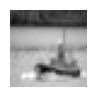

Label: ship


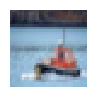

Label: ship


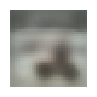

In [40]:
display_image(trainset_grayscale,idx)
display_image(trainset,idx)
imshow(test_output.squeeze(0).to('cpu'),1)

# Run inference on Random Test sample

In [37]:
#randomly select an image from the testset_grayscale
import random
idx = random.randint(0, len(testset_grayscale))
print(idx)
input_img, _ = testset_grayscale[idx]
input_tensor = input_img.reshape(1,1,32,32).to(device)
test_output = run_inference(model_infer, input_tensor)

4133


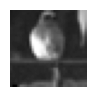

Label: bird


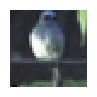

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bird


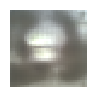

In [38]:
display_image(testset_grayscale,idx)
display_image(testset,idx)
imshow(test_output.squeeze(0).to('cpu'),1)